## Ethena Price Drivers

Key Questions
1) General understanding of Ethena
- How much of ENA price/returns can be explained by ETH price/returns?
- The supply and demand flow: 
-- What is the amount of ENA that is being claimed (and sold) on average? How much of claimed ethena has been sold?
-- What is the demand for ENA? Proxied by Pendle yields
- How has ENA liquidity been moving over time? Is it worth providing liquidity given the recent impermanent loss?
- Can we predict ENA price using the basis yield

2) Can we predict ENA price using these variables?

ETH and ENA price data has been fetched with Yahoo Finance. The Pendle yield has been fetched from the Pendle API, and Season 1 ENA claims from Dune Analytics.


In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error, r2_score


# UTILS

In [254]:
def mean_directional_accuracy(actual, predicted):
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

# Define a function to create sequences from the data
def create_sequences(data, sequence_length=1):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])
        y.append(data[i+sequence_length, -1])
    return np.array(X), np.array(y)

# DATA MANIPULATION

In [255]:
import pandas as pd

def to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col])
    return df

def shift_data(df, columns, periods=-1):
    for col in columns:
        df[f'Target_{col}'] = df[col].shift(periods)
        df[f'{col}_Change'] = df[col].diff()
        df[f'Target_{col}_Change'] = df[f'Target_{col}'].diff()
    return df

def prepare_circulating_supply(supply_dict):
    df = pd.DataFrame.from_dict(supply_dict, orient='index', columns=['Circulating Supply'])
    df.index = pd.to_datetime(df.index)
    df = df.resample('D').bfill()
    df.index.name = 'Datetime'
    df.reset_index(inplace=True)
    df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
    return df

def merge_supply(df, supply_df, stake_column):
    df = df.merge(supply_df, how='left', on='Datetime')
    df['Liquid Circulating Supply'] = df['Circulating Supply'] - df[stake_column]
    df['Liquid Circulating Supply Change'] = df['Liquid Circulating Supply'].diff()
    return df

In [256]:
# Load data
df = pd.read_csv('ena_1h_data.csv')
df_daily = pd.read_csv('ena_1d_data.csv')

# Convert 'Datetime' columns to datetime type
df, df_daily = to_datetime(df, ['Datetime']), to_datetime(df_daily, ['Datetime'])

# Shift data and calculate changes
df = shift_data(df, ['ENA_Price', 'ENA_Returns'])
df_daily = shift_data(df_daily, ['ENA_Price', 'ENA_Returns'])

# Circulating supply dictionary
circulating_supply = {
    '2024-04-08': 1425000000, '2024-05-01': 1425000000,
    '2024-06-01': 1520312500, '2024-07-01': 1615625000, '2024-07-06': 1710937500
}

# Prepare circulating supply DataFrame
circulating_supply_df = prepare_circulating_supply(circulating_supply)

# Merge and calculate liquid supply
df_daily = merge_supply(df_daily, circulating_supply_df, 'Total_Stake')

# DATA VIZ

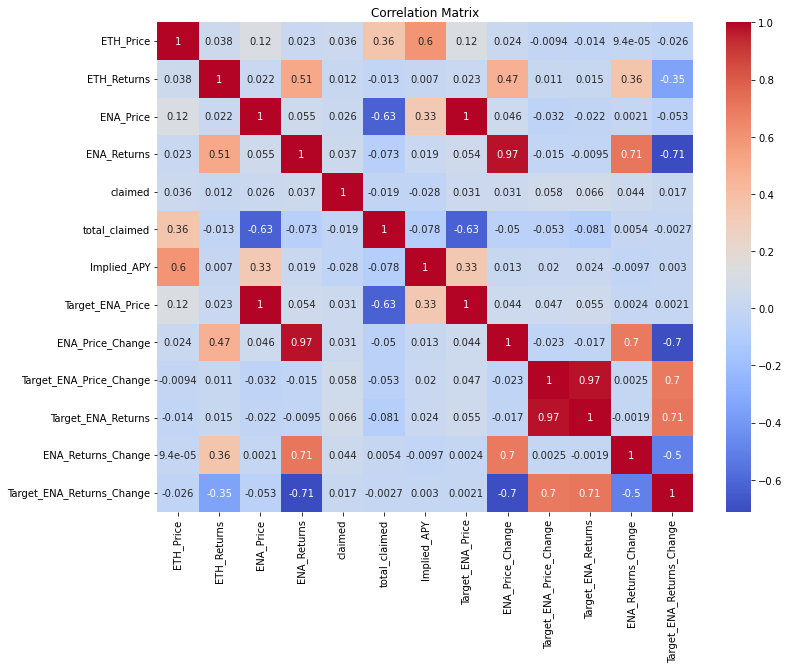

In [257]:
# Create and visualize a correlation matrix with seaborn
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### How much ENA is being claimed daily?

- The amount of ENA being claimed daily has slowed down significantly, and only about ~4% of ENA remains unclaimed. This is a good sign as it means that the ENA supply will be more stable in the future.
- Addresses that received more than 1000 ENA have sold on 91% of their airdrop on average. That for sure has created a lot of selling pressure, and only 4% of the supply remains unclaimed. On the other hand, the heavy selling might indicate that people see no use case for the token.  

Text(0.5, 0, 'Date')

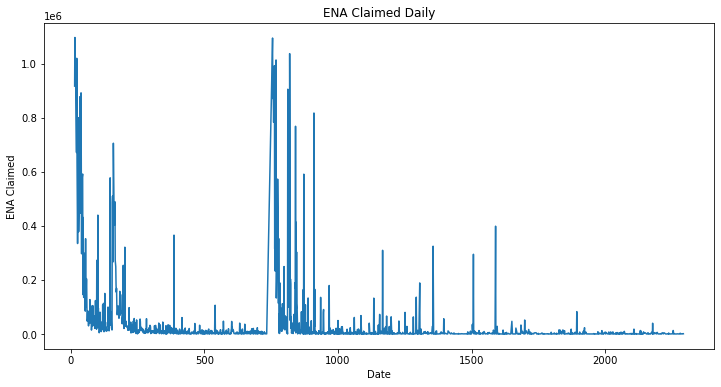

In [258]:
# plot how much ena is claimed daily, make the visualization beautiful. First drop outlier values, 99% percentile. Date as x-axis
plot_claims = df[df['claimed'] < df['claimed'].quantile(0.98)]
plot_claims['claimed'].plot(kind='line', figsize=(12, 6))
plot_claims.set_index('Datetime', inplace=True)
plt.ylabel('ENA Claimed')
plt.title('ENA Claimed Daily')
plt.xlabel('Date')

/tmp/ipykernel_328828/2822446517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_claims['claimed_pct'] =  (plot_claims['total_claimed'] / 750000000)


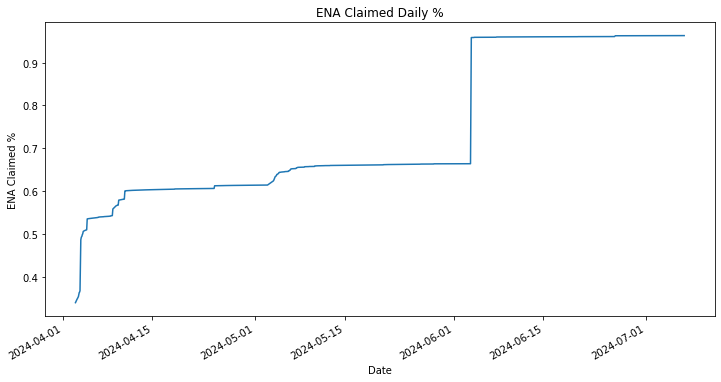

In [259]:
plot_claims['claimed_pct'] =  (plot_claims['total_claimed'] / 750000000)

# Visualize claimed_pct beautifully
plot_claims['claimed_pct'].plot(kind='line', figsize=(12, 6))
plt.ylabel('ENA Claimed %')
plt.title('ENA Claimed Daily %')
plt.xlabel('Date')
plt.show()

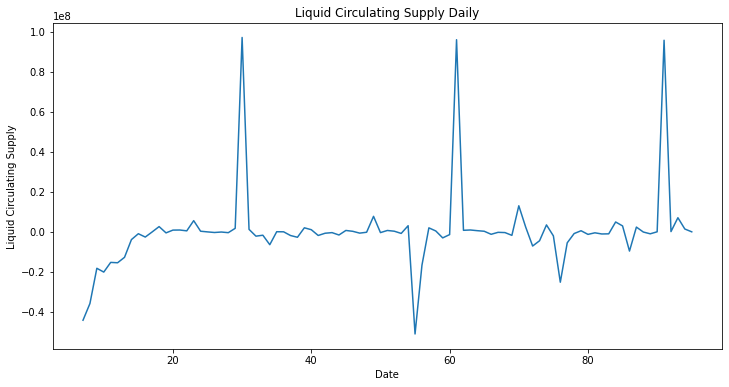

In [260]:
# plot the liquid circulating supply
df_daily['Liquid Circulating Supply Change'].plot(kind='line', figsize=(12, 6))
plt.ylabel('Liquid Circulating Supply')
plt.title('Liquid Circulating Supply Daily')
plt.xlabel('Date')
plt.show()

In [261]:
# Download ENA Airdrop receiver data
ena_airdrop_receivers = pd.read_csv('ena_claimed_data.csv')

ena_airdrop_receivers[['Claimed', 'Balance', 'Change%']].describe()

,Claimed,Balance,Change%
count,2.047200e+04,2.047200e+04,20472.000000
mean,3.493381e+04,2.321360e+03,-0.910270
std,2.246026e+06,1.465308e+05,0.520545
min,1.000047e+03,-3.352761e-08,-1.000000
25%,1.921611e+03,0.000000e+00,-1.000000
50%,3.849610e+03,0.000000e+00,-1.000000
75%,7.699220e+03,4.547474e-13,-1.000000
max,3.198192e+08,1.875000e+07,36.154996


## Granger causality

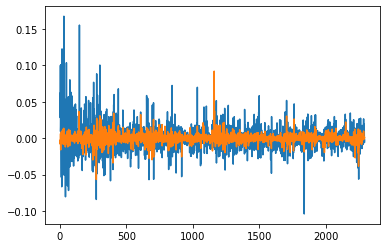

In [262]:
# Do a granger causality test on ENA price and ETH Price
from statsmodels.tsa.stattools import grangercausalitytests

ena_returns = df['ENA_Returns']
eth_returns = df['ETH_Returns']


plt.plot(ena_returns, label='ENA Price')
plt.plot(eth_returns, label='ETH Price')

granger_test_df = pd.DataFrame(data={'ENA_Returns': ena_returns, 'ETH_Returns': eth_returns})
granger_test_df.dropna(inplace=True)

In [263]:
gc_res = grangercausalitytests(granger_test_df.dropna(), 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2325  , p=0.2670  , df_denom=2289, df_num=1
ssr based chi2 test:   chi2=1.2341  , p=0.2666  , df=1
likelihood ratio test: chi2=1.2338  , p=0.2667  , df=1
parameter F test:         F=1.2325  , p=0.2670  , df_denom=2289, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9747  , p=0.3774  , df_denom=2286, df_num=2
ssr based chi2 test:   chi2=1.9538  , p=0.3765  , df=2
likelihood ratio test: chi2=1.9529  , p=0.3766  , df=2
parameter F test:         F=0.9747  , p=0.3774  , df_denom=2286, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7404  , p=0.5279  , df_denom=2283, df_num=3
ssr based chi2 test:   chi2=2.2280  , p=0.5265  , df=3
likelihood ratio test: chi2=2.2269  , p=0.5267  , df=3
parameter F test:         F=0.7404  , p=0.5279  , df_denom=2283, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6358  , p=0.

In [264]:
gc_results = grangercausalitytests(df[['ENA_Returns', 'ETH_Returns']].dropna(), maxlag=10, verbose=False)

# Extracting p-values and F-statistics
p_values = [gc_results[i+1][0]['ssr_ftest'][1] for i in range(10)]
f_stats = [gc_results[i+1][0]['ssr_ftest'][0] for i in range(10)]
lags = list(range(1, 11))

# Create a DataFrame from the extracted values
results_df = pd.DataFrame({
    'Lag': lags,
    'P-Value': p_values,
    'F-Statistic': f_stats
})


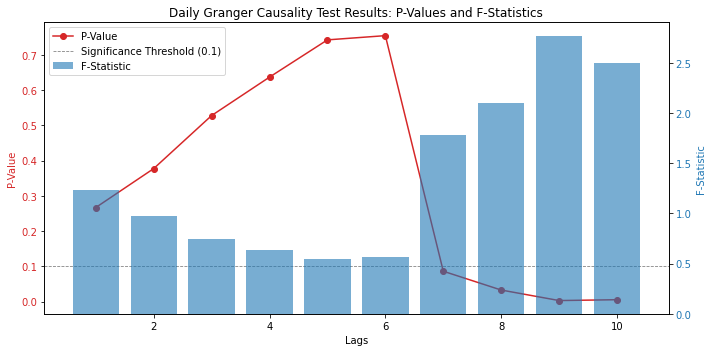

In [265]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Line plot for P-Values
color = 'tab:red'
ax1.set_xlabel('Lags')
ax1.set_ylabel('P-Value', color=color)
p_values_line, = ax1.plot(results_df['Lag'], results_df['P-Value'], color=color, marker='o', linestyle='-', label='P-Value')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0.1, color='grey', linestyle='--', linewidth=0.8, label='Significance Threshold (0.1)')  # Significance level line
ax1.set_title('Daily Granger Causality Test Results: P-Values and F-Statistics')

# Create a twin axis for the F-statistic
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('F-Statistic', color=color)
f_statistics_bar = ax2.bar(results_df['Lag'], results_df['F-Statistic'], color=color, alpha=0.6, label='F-Statistic')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a legend to the plot
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax2.legend(lines + [f_statistics_bar], labels + bar_labels, loc='upper left')

fig.tight_layout()
plt.show()


#### Results
On 1d and 4h timeframe, no significant p-values are observed even with 10 lags. On 1h timeframe, p-values start becoming signicant after 7 lags, indicating ETH returns might granger cause ENA returns.

## Cointegration test

In [266]:
# Test if ENA and ETH prices are cointegrated
from statsmodels.tsa.stattools import coint

cointegration_df = df_daily.dropna()[['ENA_Price', 'ETH_Price']]

coint(cointegration_df['ENA_Price'], cointegration_df['ETH_Price'])

(-1.3527483181663502,
 0.8132505392793921,
 array([-4.10270065, -3.44741463, -3.12105306]))

In [267]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test on ENA and ETH Prices
adf_ena_price = adfuller(df['ENA_Price'])
adf_eth_price = adfuller(df['ETH_Price'])

# Perform ADF Test on the Spread
spread = df['ETH_Price']- df['ENA_Price']
adf_spread = adfuller(spread)
adf_spread_2 = adfuller(df['ENA_Price'] / df['ETH_Price'])

# Print p-values
print('ADF Test Results for ENA Price:', adf_ena_price[1])
print('ADF Test Results for ETH Price:', adf_eth_price[1])
print('ADF Test Results for Spread:', adf_spread[1])
print('ADF Test Results for Spread:', adf_spread_2[1])

ADF Test Results for ENA Price: 0.7428850179348142
ADF Test Results for ETH Price: 0.4862436659913873
ADF Test Results for Spread: 0.48632865778327916
ADF Test Results for Spread: 0.8226570284418092


### Results
P-value for all time frames is about 0.9, indicating that the two time series are not cointegrated.

## Fetch funding data
- Try to get Derivative Yields data from Ethena
- Use Binance ETH funding data as a proxy for the demand for ENA

In [268]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def fetch_futures_funding_rates(symbol, start_date, end_date, limit=1000):
    """ Fetches futures funding rates from Binance API. """
    base_url = 'https://fapi.binance.com/fapi/v1/fundingRate'
    start_time = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)  # convert to milliseconds
    end_time = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)  # convert to milliseconds
    
    params = {
        'symbol': symbol,
        'limit': limit,
        'startTime': start_time,
        'endTime': end_time
    }
    
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return pd.DataFrame(data)
    else:
        raise Exception(f"Failed to fetch data: {response.status_code} {response.text}")

# Define your parameters
symbol = 'ETHUSDT'  # ETH/USDT perpetual contract
start_date = '2024-04-01'  # Start date (format YYYY-MM-DD)
end_date = datetime.now().strftime('%Y-%m-%d')  # Today's date

# Fetch the data
funding_data = fetch_futures_funding_rates(symbol, start_date, end_date)

# Display the data
funding_data

,symbol,fundingTime,fundingRate,markPrice
0,ETHUSDT,1711929600000,0.00060909,3648.79000000
1,ETHUSDT,1711958400000,0.00035798,3548.55600379
2,ETHUSDT,1711987200000,0.00019362,3445.71054924
3,ETHUSDT,1712016000007,0.00015034,3506.13451136
4,ETHUSDT,1712044800015,0.00010000,3364.75000000
...,...,...,...,...
322,ETHUSDT,1721203200001,0.00008064,3484.69353030
323,ETHUSDT,1721232000000,0.00006113,3436.30719697
324,ETHUSDT,1721260800000,0.00010000,3386.04000000
325,ETHUSDT,1721289600000,0.00006727,3431.72000000


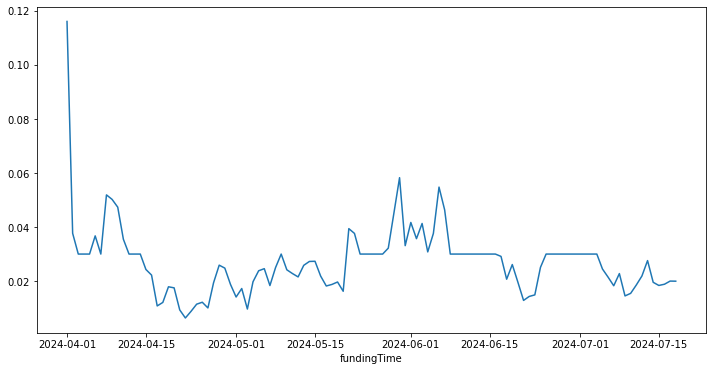

In [269]:
funding_data['fundingTime'] = pd.to_datetime(funding_data['fundingTime'], unit='ms', utc=True)

# Convert fundingRate to float values
funding_data['fundingRate'] = funding_data['fundingRate'].astype(float)
funding_data_grouped = funding_data.groupby(funding_data['fundingTime'].dt.date)['fundingRate'].mean()


# Calculate daily APY from the average funding rates (assuming 3 funding periods per day)
daily_apy = funding_data_grouped * 3 * 100  # Convert rate to percentage

# Plotting the daily APY
daily_apy.plot(kind='line', figsize=(12, 6))

daily_apy = daily_apy.reset_index()
daily_apy.columns = ['Datetime', 'Daily Funding Rate']

# Calculate 7-day moving average of the daily APY
daily_apy['Funding 7-Day MA'] = daily_apy['Daily Funding Rate'].rolling(window=7).mean()
daily_apy

# Make the Datetime column of daily_apy to datetime
daily_apy['Datetime'] = pd.to_datetime(daily_apy['Datetime'], utc=True)

# Merge the funding data with df_daily
df_daily = df_daily.merge(daily_apy, how='left', left_on='Datetime', right_on='Datetime')


Text(0.5, 1.0, 'Correlation Matrix Daily')

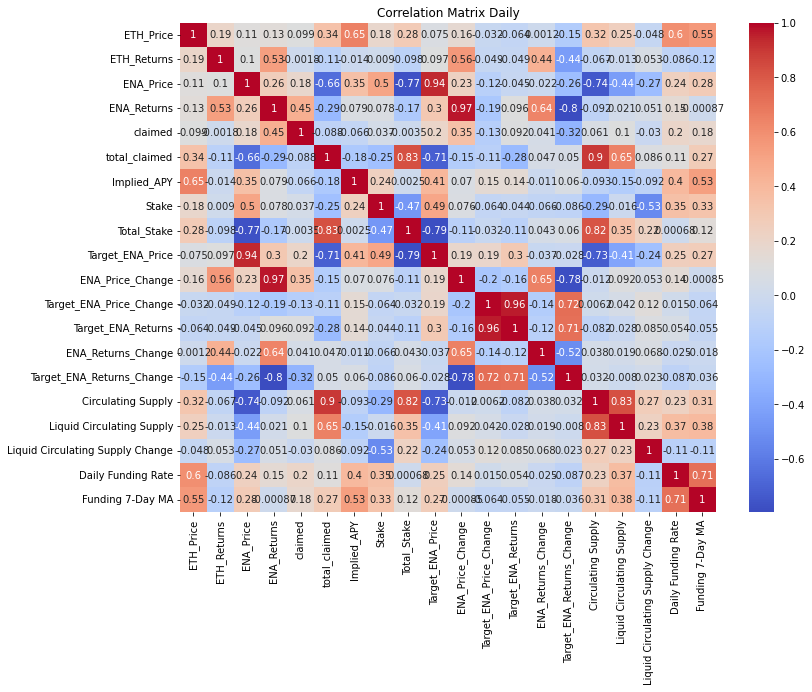

In [270]:
# Correlation matrix of df_daily, but without selected columns
correlation_matrix_daily = df_daily.corr()

# Visualize the correlation matrix with seaborn

plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix_daily, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Daily')


In [271]:
correlation_matrix['Target_ENA_Returns'].sort_values(ascending=False)

Target_ENA_Returns           1.000000
Target_ENA_Price_Change      0.974924
Target_ENA_Returns_Change    0.709550
claimed                      0.065855
Target_ENA_Price             0.055396
Implied_APY                  0.023775
ETH_Returns                  0.015111
ENA_Returns_Change          -0.001925
ENA_Returns                 -0.009482
ETH_Price                   -0.013970
ENA_Price_Change            -0.017131
ENA_Price                   -0.022202
total_claimed               -0.081481
Name: Target_ENA_Returns, dtype: float64

/tmp/ipykernel_328828/129453510.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_test['Implied_APY_Quartile'] = pd.qcut(df_daily_test['Implied_APY'], q=4, labels=False)
/tmp/ipykernel_328828/129453510.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_test['Implied_APY_Quartile'] += 1  # Shift quartiles from 0-3 to 1-4 for labeling


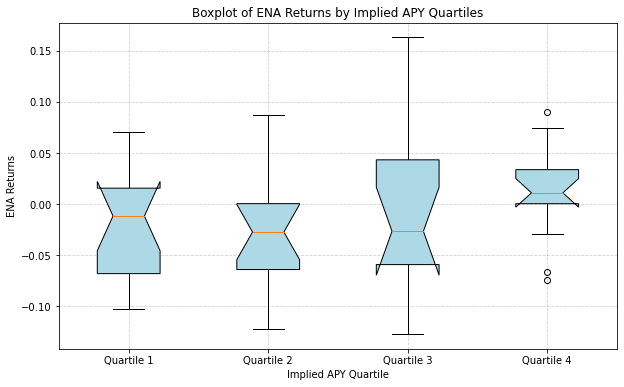

In [272]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_daily already has 'Implied_APY' and 'Target_ENA_Returns'
df_daily_test = df_daily.dropna()

# Create quartiles of 'Implied_APY'
df_daily_test['Implied_APY_Quartile'] = pd.qcut(df_daily_test['Implied_APY'], q=4, labels=False)
df_daily_test['Implied_APY_Quartile'] += 1  # Shift quartiles from 0-3 to 1-4 for labeling

# Prepare data for plotting
data_to_plot = [df_daily_test[df_daily_test['Implied_APY_Quartile'] == i]['Target_ENA_Returns'] for i in range(1, 5)]

# Create the plot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, notch=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Adding customizations
plt.title('Boxplot of ENA Returns by Implied APY Quartiles')
plt.xlabel('Implied APY Quartile')
plt.ylabel('ENA Returns')
plt.xticks(ticks=range(1, 5), labels=[f'Quartile {i}' for i in range(1, 5)])
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [273]:
import pandas as pd
from scipy.stats import f_oneway
import numpy as np

# Assuming df_daily already has 'Implied_APY' and 'Target_ENA_Returns'
# and you have previously added the 'Implied_APY_Quartile' to df_daily as done in the previous examples.

# Group data by 'Implied_APY_Quartile'
grouped = df_daily_test.groupby('Implied_APY_Quartile')['Target_ENA_Returns']

# Extract individual groups for ANOVA
data_groups = [group for _, group in grouped]

# Perform one-way ANOVA test
anova_results = f_oneway(*data_groups)

print(f"ANOVA test results: F-statistic = {anova_results.statistic:.2f}, p-value = {anova_results.pvalue:.5f}")


ANOVA test results: F-statistic = 1.19, p-value = 0.32290


In [274]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis Test
kruskal_results = kruskal(*data_groups)

print(f"Kruskal-Wallis Test results: H-statistic = {kruskal_results.statistic:.2f}, p-value = {kruskal_results.pvalue:.5f}")


Kruskal-Wallis Test results: H-statistic = 3.85, p-value = 0.27846


## Does Basis Yield have predictibve power for ENA returns?

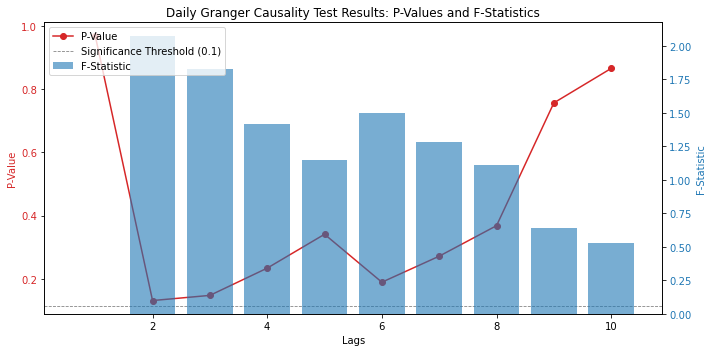

In [275]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming df_daily already has 'ENA_Returns' and 'Daily Funding Rate'
# Calculate the first difference of the Daily Funding Rate to get the change
df_daily['DFR_Change'] = df_daily['Daily Funding Rate'].diff().fillna(0)  # Using fillna(0) to handle the NA value in the first row

# Prepare the DataFrame for the Granger causality test
df_test = df_daily[['ENA_Returns', 'DFR_Change']].dropna()

# Perform Granger causality tests for 10 lags
gc_results = grangercausalitytests(df_test, maxlag=10, verbose=False)

# Extract p-values and F-statistics from the test results
results_df = pd.DataFrame({
    'Lag': range(1, 11),
    'P-Value': [gc_results[i+1][0]['ssr_ftest'][1] for i in range(10)],
    'F-Statistic': [gc_results[i+1][0]['ssr_ftest'][0] for i in range(10)]
})

fig, ax1 = plt.subplots(figsize=(10, 5))

# Line plot for P-Values
color = 'tab:red'
ax1.set_xlabel('Lags')
ax1.set_ylabel('P-Value', color=color)
p_values_line, = ax1.plot(results_df['Lag'], results_df['P-Value'], color=color, marker='o', linestyle='-', label='P-Value')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0.115, color='grey', linestyle='--', linewidth=0.8, label='Significance Threshold (0.1)')  # Significance level line
ax1.set_title('Daily Granger Causality Test Results: P-Values and F-Statistics')

# Create a twin axis for the F-statistic
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('F-Statistic', color=color)
f_statistics_bar = ax2.bar(results_df['Lag'], results_df['F-Statistic'], color=color, alpha=0.6, label='F-Statistic')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a legend to the plot
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax2.legend(lines + [f_statistics_bar], labels + bar_labels, loc='upper left')

fig.tight_layout()
plt.show()


In [276]:
# Creating lagged versions of Basis Yield
for lag in range(1, 6):
    df_daily[f'DFR Lag: {lag}'] = df_daily['DFR_Change'].shift(lag)

# Example using a simple linear regression model to predict ENA Returns using different lags
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
results = {}
for lag in range(1, 6):
    df_temp = df_daily[['ENA_Returns', f'DFR Lag: {lag}']].dropna()
    X = df_temp[f'DFR Lag: {lag}'].values.reshape(-1, 1)
    y = df_temp['ENA_Returns']
    model.fit(X, y)
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    results[f'Lag {lag}'] = r2

print(results)


{'Lag 1': 0.00015943826246722637, 'Lag 2': 0.03974771643063413, 'Lag 3': 0.02899955311175284, 'Lag 4': 0.002891641803967504, 'Lag 5': 0.014094402365916747}


# Baseline Models for ENA price / return prediction

SMA Model - Mean Squared Error: 0.006576467140111593
SMA Model - R^2 Score: -0.3821552104696404
SMA Model - MDA Score 0.978494623655914


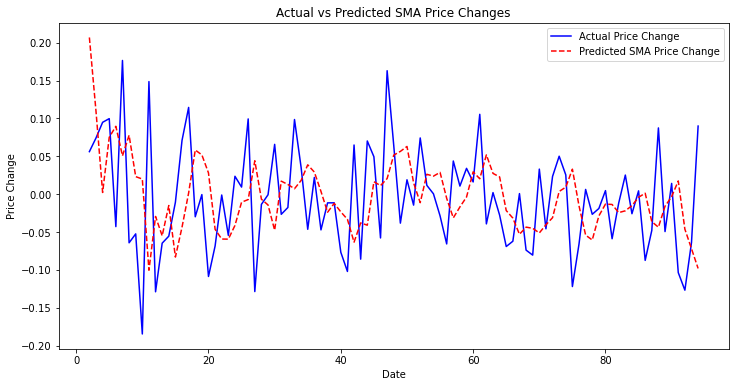

In [277]:
# Import mse

# Define the window size for SMA
window_size = 3

# Calculate the SMA for Price Change and use it to predict the next day
df_daily['SMA_Returns'] = df_daily['ENA_Returns'].rolling(window=window_size).mean()

# Drop any NaN values that were created by rolling mean calculation
df_sma= df_daily.dropna(subset=['SMA_Returns', 'Target_ENA_Returns'])

# Setting up the target and predictions
actual_price = df_sma['Target_ENA_Returns']
predicted_price = df_sma['SMA_Returns']

# Evaluate the model performance
mse_sma = mean_squared_error(actual_price, predicted_price)
r2_sma = r2_score(actual_price, predicted_price)
# Get Mean Directional Accuracy
mda_sma = mean_directional_accuracy(actual_price, predicted_price)

print("SMA Model - Mean Squared Error:", mse_sma)
print("SMA Model - R^2 Score:", r2_sma)
print("SMA Model - MDA Score", mda_sma)

# Optionally, you can plot actual vs. predicted prices for visual analysis
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_price.index, actual_price, label='Actual Price Change', color='blue')
plt.plot(predicted_price.index, predicted_price, label='Predicted SMA Price Change', linestyle='--', color='red')
plt.title('Actual vs Predicted SMA Price Changes')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.legend()
plt.show()

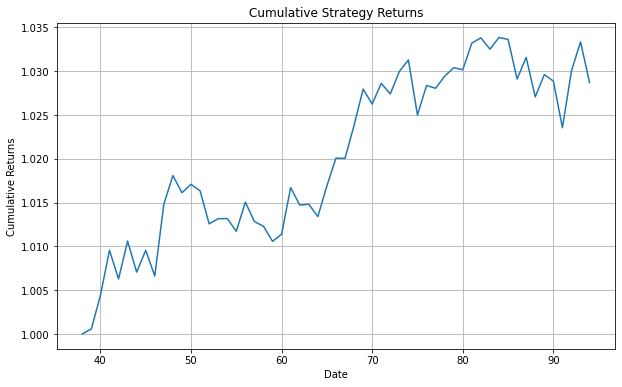

Win Rate: 0.56


In [278]:
# Assuming df_sma already exists and has been cleaned
df_sma = df_daily.copy().dropna()
df_sma = df_sma[['ENA_Returns', 'Target_ENA_Returns', 'SMA_Returns']]
df_sma['Signal'] = np.where(df_sma['SMA_Returns'] > 0, 1, -1)

# Initial portfolio value and risk per trade
initial_portfolio_value = 10000
risk = 0.05

# Initialize portfolio value series
df_sma['Portfolio_Value'] = np.nan
df_sma.at[df_sma.index[0], 'Portfolio_Value'] = initial_portfolio_value

# Calculate the portfolio value over time
for i in range(1, len(df_sma)):
    previous_value = df_sma.at[df_sma.index[i-1], 'Portfolio_Value']
    position_size = previous_value * risk
    trade_return = position_size * df_sma.at[df_sma.index[i], 'Target_ENA_Returns'] * df_sma.at[df_sma.index[i], 'Signal']
    df_sma.at[df_sma.index[i], 'Portfolio_Value'] = previous_value + trade_return

# Calculate cumulative strategy returns
df_sma['Cumulative_Strategy_Returns'] = df_sma['Portfolio_Value'] / initial_portfolio_value

# Plot cumulative strategy returns
plt.figure(figsize=(10, 6))
df_sma['Cumulative_Strategy_Returns'].plot()
plt.title('Cumulative Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Print out win rate
win_rate = (df_sma['Signal'] == np.sign(df_sma['Target_ENA_Returns'])).mean()
print(f"Win Rate: {win_rate:.2f}")


In [279]:
df_daily

,Datetime,ETH_Price,ETH_Returns,ENA_Price,ENA_Returns,claimed,total_claimed,Implied_APY,Stake,Total_Stake,...,Liquid Circulating Supply Change,Daily Funding Rate,Funding 7-Day MA,DFR_Change,DFR Lag: 1,DFR Lag: 2,DFR Lag: 3,DFR Lag: 4,DFR Lag: 5,SMA_Returns
0,2024-04-02 00:00:00+00:00,3277.858398,-0.015094,0.784684,0.348850,9.564195e+07,2.535212e+08,NaN,NaN,NaN,...,NaN,0.037676,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-03 00:00:00+00:00,3314.096680,0.011399,1.128263,0.395493,1.162109e+08,3.697320e+08,NaN,NaN,NaN,...,NaN,0.030000,NaN,-0.007676,0.000000,NaN,NaN,NaN,NaN,NaN
2,2024-04-04 00:00:00+00:00,3331.051025,0.005471,0.977878,-0.123795,3.168376e+07,4.014158e+08,NaN,NaN,NaN,...,NaN,0.030000,NaN,0.000000,-0.007676,0.000000,NaN,NaN,NaN,0.206850
3,2024-04-05 00:00:00+00:00,3318.539062,-0.003357,1.019053,0.056065,1.466231e+06,4.028820e+08,NaN,NaN,NaN,...,NaN,0.030000,NaN,0.000000,0.000000,-0.007676,0.000000,NaN,NaN,0.109255
4,2024-04-06 00:00:00+00:00,3354.390869,0.010855,1.088000,0.074112,1.857442e+06,4.047395e+08,NaN,NaN,NaN,...,NaN,0.036732,NaN,0.006732,0.000000,0.000000,-0.007676,0.0,NaN,0.002128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024-07-02 00:00:00+00:00,3416.722900,-0.007084,0.511715,0.014115,6.699557e+04,7.221570e+08,0.735242,-3.760116e+05,3.182216e+08,...,9.568851e+07,0.030000,0.030000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.017333
92,2024-07-03 00:00:00+00:00,3294.780273,-0.035992,0.460572,-0.103683,1.372125e+04,7.221707e+08,0.758583,-1.161495e+05,3.181054e+08,...,1.161495e+05,0.030000,0.030000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.046359
93,2024-07-04 00:00:00+00:00,3062.264404,-0.072368,0.404536,-0.126895,9.232039e+03,7.221799e+08,0.793846,-7.046414e+06,3.110590e+08,...,7.046414e+06,0.030000,0.030000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.072154
94,2024-07-05 00:00:00+00:00,2982.219238,-0.024760,0.377443,-0.064062,1.867544e+04,7.221986e+08,0.797063,-1.402886e+06,3.096561e+08,...,1.402886e+06,0.024473,0.029210,-0.005527,0.000000,0.000000,0.000000,0.0,0.0,-0.098213


In [280]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!11 Stationarize 7-day MA, Liquid Circulating Supply, and Funding Rate
df_daily['Funding 7-Day MA'] = df_daily['Funding 7-Day MA'].diff()
df_daily['Liquid Circulating Supply'] = df_daily['Liquid Circulating Supply'].diff()
df_daily['Implied_APY'] = df_daily['Implied_APY'].diff()

df_daily.dropna(inplace=True)
# Setting up the features and target variable

predicted_variable = ['Target_ENA_Returns']
features = ['Funding 7-Day MA', 'Liquid Circulating Supply', 'Implied_APY', 'Stake', 'claimed']

# Split the data into features and target
X = df_daily[features]
y = df_daily[predicted_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the target values for the test set
y_pred = model.predict(X_test)

y_test_flat = y_test.values.flatten()  # Flatten y_test to one dimension
y_pred_flat = y_pred.flatten()         # Flatten y_pred to one dimension

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mda = mean_directional_accuracy(y_test_flat, y_pred_flat)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("MDA Score:", mda)

# To see the importance of each feature, you can look at the coefficients
coefficients = pd.DataFrame(model.coef_.flatten(), index=features, columns=['Coefficient'])
print(coefficients.sort_values(by='Coefficient', ascending=False))

Mean Squared Error: 0.0037267982407730572
R^2 Score: -0.06024539218520841
MDA Score: 0.36363636363636365
                            Coefficient
Funding 7-Day MA           1.104992e+00
Implied_APY                1.039004e-01
Liquid Circulating Supply  1.242476e-10
claimed                   -1.167380e-10
Stake                     -1.050360e-09


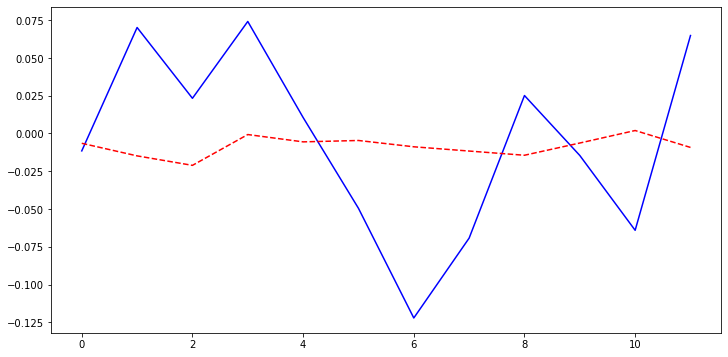

In [281]:
# plot y_Test flat and y_pred flat

plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='Actual Price Change', color='blue')
plt.plot(y_pred_flat, label='Predicted Price Change', linestyle='--', color='red')

## Random Forest Regression

In [282]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define the feature sets
features_1 = ['ETH_Returns', 'ENA_Returns', 'claimed', 'Implied_APY', 'Stake', 'Total_Stake', 'Circulating Supply', 'Liquid Circulating Supply', 'Liquid Circulating Supply Change', 'Funding 7-Day MA', 'Target_ENA_Returns', 'SMA_Returns']
features_2 = ['Funding 7-Day MA', 'Implied_APY', 'Stake', 'claimed', 'Target_ENA_Returns']
features_3 = ['Funding 7-Day MA', 'Implied_APY', 'ETH_Price', 'Target_ENA_Returns']
features_4 = ['Implied_APY', 'claimed', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'Target_ENA_Returns']
features_5 = ['Stake', 'Funding 7-Day MA', 'Implied_APY', 'Target_ENA_Returns']

feature_sets = [features_2, features_3, features_4, features_5, features_1]

# Dictionary to store model performance
model_performance = {}

# Loop through each feature set
for idx, features in enumerate(feature_sets):
    random_forest_data = df_daily[features]
    random_forest_data.dropna(inplace=True)

    X = random_forest_data.drop('Target_ENA_Returns', axis=1)
    y = random_forest_data['Target_ENA_Returns']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test.values.flatten(), y_pred)

    # Store performance metrics in the dictionary
    model_performance[f"Model {idx+1}"] = {
        'Features': features,
        'MSE': mse,
        'MAE': mae,
        'MDA': mda,
        'R2': r2
    }

# Print a summary of all models' performance
for model_name, performance in model_performance.items():
    print(f"{model_name}:")
    print(f"Features: {performance['Features']}")
    print(f"Mean Squared Error: {performance['MSE']}")
    print(f"Mean Absolute Error: {performance['MAE']}")
    print('Mean Directional Accuracy:', performance['MDA'])
    print(f"R^2 Score: {performance['R2']}")
    print()


/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Model 1:
Features: ['Funding 7-Day MA', 'Implied_APY', 'Stake', 'claimed', 'Target_ENA_Returns']
Mean Squared Error: 0.003569425431664129
Mean Absolute Error: 0.051186478622169934
Mean Directional Accuracy: 0.2727272727272727
R^2 Score: -0.015474040227509755

Model 2:
Features: ['Funding 7-Day MA', 'Implied_APY', 'ETH_Price', 'Target_ENA_Returns']
Mean Squared Error: 0.005204591657937712
Mean Absolute Error: 0.061305972187041015
Mean Directional Accuracy: 0.36363636363636365
R^2 Score: -0.4806662360099736

Model 3:
Features: ['Implied_APY', 'claimed', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'Target_ENA_Returns']
Mean Squared Error: 0.0035454491573826707
Mean Absolute Error: 0.05084172716722101
Mean Directional Accuracy: 0.36363636363636365
R^2 Score: -0.008652974882310982

Model 4:
Features: ['Stake', 'Funding 7-Day MA', 'Implied_APY', 'Target_ENA_Returns']
Mean Squared Error: 0.0034016737463149274
Mean Absolute Error: 0.04895622959506237
Mean Directional Accuracy: 0.545454545

/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0.005307506336398167
-0.5099446692860627
ENA_Returns                         0.170759
SMA_Returns                         0.158587
ETH_Returns                         0.135928
claimed                             0.126820
Total_Stake                         0.109167
Implied_APY                         0.088022
Funding 7-Day MA                    0.074587
Stake                               0.042053
Liquid Circulating Supply           0.037454
Liquid Circulating Supply Change    0.030650
Circulating Supply                  0.025972
dtype: float64


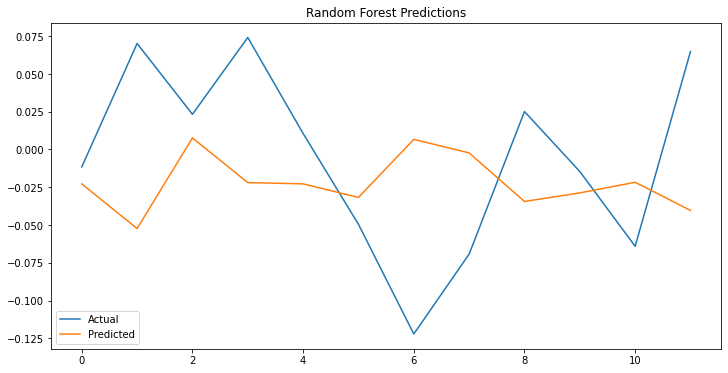

In [283]:
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error
from sklearn.metrics import mean_squared_error, r2_score
# Import grid search
from sklearn.model_selection import GridSearchCV

mse = mean_squared_error(y_test, y_pred)
print(mse)

# Print out R2
r2 = r2_score(y_test, y_pred)
print(r2)

# Print out feature importances
feature_importances = model.feature_importances_
features = X.columns
importances = pd.Series(feature_importances, index=features).sort_values(ascending=False)
print(importances)

# Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Random Forest Predictions')
plt.show()

In [284]:
df_daily.to_csv('daily_df_complete.csv', index=False)

## Bidirectional LSTM

Testing ['ETH_Returns', 'ENA_Returns', 'claimed', 'Implied_APY', 'Stake', 'Total_Stake', 'Circulating Supply', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'SMA_Returns'] with LR=0.01, Batch=8, Units=50
1/1 [==============================] - 0s 429ms/step
Testing ['ETH_Returns', 'ENA_Returns', 'claimed', 'Implied_APY', 'Stake', 'Total_Stake', 'Circulating Supply', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'SMA_Returns'] with LR=0.01, Batch=8, Units=64
1/1 [==============================] - 0s 441ms/step
Testing ['ETH_Returns', 'ENA_Returns', 'claimed', 'Implied_APY', 'Stake', 'Total_Stake', 'Circulating Supply', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'SMA_Returns'] with LR=0.01, Batch=8, Units=128
1/1 [==============================] - 0s 414ms/step
Testing ['ETH_Returns', 'ENA_Returns', 'claimed', 'Implied_APY', 'Stake', 'Total_Stake', 'Circulating Supply', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'SMA_Returns'] with LR=0.01, Batch=16, Units=50
1/1 [======

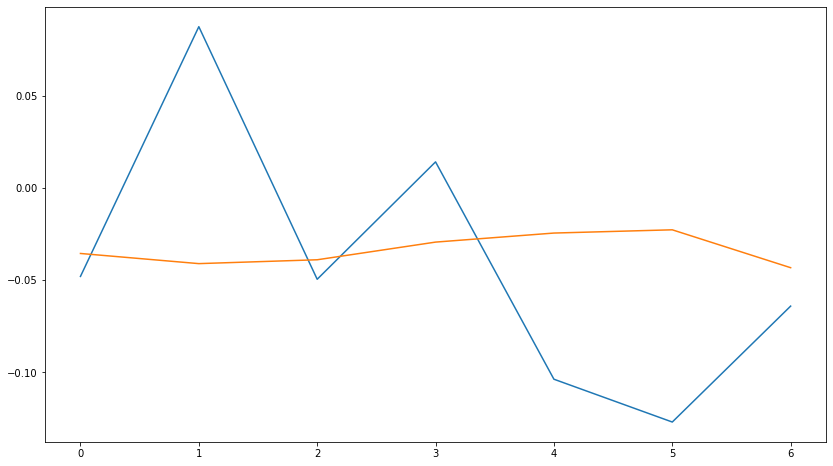

In [393]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the mean directional accuracy
def mean_directional_accuracy(actual, predicted):
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))


# Define different feature subsets
feature_sets = [
    #['ENA_Returns', 'claimed', 'Total_Stake', 'ETH_Returns', 'Implied_APY'],
    ['ETH_Returns', 'ENA_Returns', 'claimed', 'Implied_APY', 'Stake', 'Total_Stake', 'Circulating Supply', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'SMA_Returns'],
    #['Funding 7-Day MA', 'Implied_APY', 'Stake', 'claimed'],
    #['Stake', 'Funding 7-Day MA', 'Implied_APY']
]

# Load and preprocess data
data = df_daily

# Hyperparameters
learning_rates = [0.01]
batch_sizes = [8, 16, 32]
num_units = [50, 64, 128]
sequence_lengths = [3, 5, 7, 10]
performance_records = []

# Convert an array of values into a dataset matrix
def create_dataset(data, sequence_length):
    X, y = [], []
    # Check if data is a DataFrame and convert to NumPy array if not already
    if isinstance(data, pd.DataFrame):
        data = data.values
    
    for i in range(len(data) - sequence_length):
        # Using .iloc in pandas to handle row and column slicing if it's a DataFrame
        # If data is a numpy array, normal slicing will be used
        X.append(data[i:(i + sequence_length), :-1])  # Inputs: all columns except the last
        y.append(data[i + sequence_length, -1])       # Outputs: the last column
    return np.array(X), np.array(y)


# Loop through feature sets
for features in feature_sets:
    for sequence_length in sequence_lengths:
        scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaler = MinMaxScaler(feature_range=(0, 1))    

        features_scaled = scaler.fit_transform(data[features])
        target_scaled = y_scaler.fit_transform(data[['ENA_Returns']]) # Predict t+1 ENA Returns

        # Combine the scaled data and the target variable
        data_scaled = np.concatenate((features_scaled, target_scaled), axis=1)

        # Train-test split
        train_size = int(len(data_scaled) * 0.7)
        train, test = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

        look_back = sequence_length
        X_train, y_train = create_dataset(train, look_back)
        X_test, y_test = create_dataset(test, look_back)

        # Reshape the input to be [samples, time steps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

        for lr in learning_rates:
            for batch_size in batch_sizes:
                for units in num_units:
                    print(f"Testing {features} with LR={lr}, Batch={batch_size}, Units={units}")
                    model = Sequential([
                        LSTM(units, activation='tanh', return_sequences=True, input_shape=(sequence_length, X_train.shape[2])), #lookback, features
                        Dropout(0.2),
                        LSTM(units, activation='tanh'),
                        Dropout(0.2),
                        Dense(1)
                    ])

                    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error', metrics=['accuracy'])
                    model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_split=0.2, verbose=0)
                    
                    predictions = model.predict(X_test)
                    predictions = y_scaler.inverse_transform(predictions)  # Correct reverse transformation
                    y_test_inverted = y_scaler.inverse_transform(y_test.reshape(-1, 1))  # Correct reverse transformation

                    mda = mean_directional_accuracy(y_test_inverted.flatten(), predictions.flatten())
                    mse = mean_squared_error(y_test_inverted.flatten(), predictions.flatten())
                    mape = mean_absolute_percentage_error(y_test_inverted.flatten(), predictions.flatten())
                    r2 = r2_score(y_test_inverted.flatten(), predictions.flatten())

                    performance_records.append({
                        'Features': features,
                        'Learning Rate': lr,
                        'Batch Size': batch_size,
                        'Units': units,
                        'Sequence length': sequence_length,
                        'MDA': mda,
                        'MSE': mse,
                        'MAPE': mape,
                        'R2': r2
                    })

# Convert to DataFrame for easier manipulation
performance_df = pd.DataFrame(performance_records)

# Sort by MSE and select top 5 models
top_5_models = performance_df.sort_values(by='MSE').head(5)
print("Top 5 Models by MSE:")
print(top_5_models)

# Select the best model from top 5
best_model_index = top_5_models.index[0]
best_model_config = top_5_models.loc[best_model_index]

# Retrain the best model configuration
sequence_length = best_model_config['Sequence length']  # Ensure this is used correctly

# Plot out predictions vs actual
plt.figure(figsize=(14, 8))
plt.plot(y_test_inverted, label='True')
plt.plot(predictions, label='Predicted')
plt.show()


In [397]:
performance_df.sort_values(by='R2', ascending=False)

,Features,Learning Rate,Batch Size,Units,Sequence length,MDA,MSE,MAPE,R2
4,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,16,64,3,0.615385,0.002787,2.339192,0.077319
6,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,32,50,3,0.538462,0.002830,2.076694,0.063056
3,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,16,50,3,0.538462,0.002835,2.062790,0.061432
1,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,8,64,3,0.692308,0.002875,2.250787,0.048208
11,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,8,128,5,0.636364,0.003232,1.883345,0.035711
12,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,16,50,5,0.636364,0.003240,1.174585,0.033247
7,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,32,64,3,0.538462,0.002953,2.550116,0.022302
22,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,16,64,7,0.666667,0.003534,1.806820,0.016003
17,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,32,128,5,0.545455,0.003304,1.692568,0.014278
9,"[ETH_Returns, ENA_Returns, claimed, Implied_AP...",0.01,8,50,5,0.636364,0.003312,2.178739,0.011849


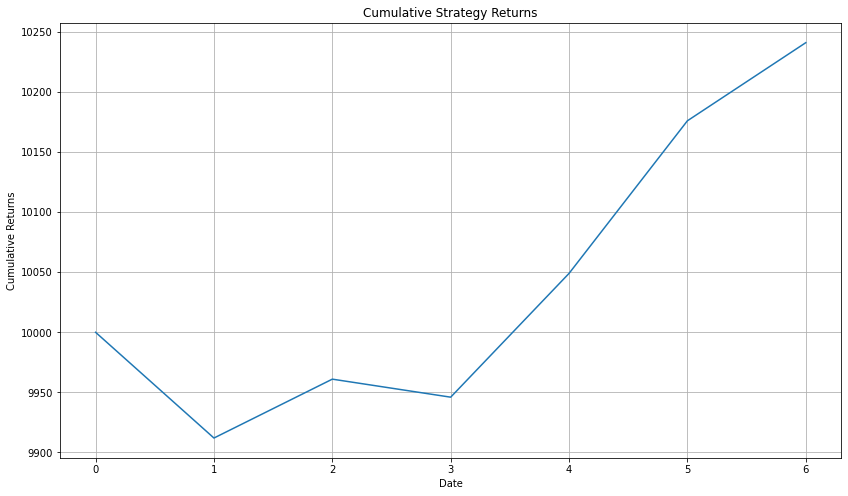

In [398]:
predictions

# Create a backtest
backtest_folio = df_daily[-len(predictions):].reset_index()

portfolio_value = 10000
fixed_risk_percentage = 0.1 

# Initialize portfolio value series
backtest_folio['Portfolio_Value'] = portfolio_value

# Calculate the portfolio value over time
for i in range(1, len(backtest_folio)):
    previous_value = backtest_folio.at[backtest_folio.index[i-1], 'Portfolio_Value']
    amount_risked = previous_value * fixed_risk_percentage  
    trade_return = amount_risked * np.sign(predictions[i-1]).item() * backtest_folio['Target_ENA_Returns'][i-1] 
    backtest_folio.at[backtest_folio.index[i], 'Portfolio_Value'] = previous_value + trade_return

# Calculate cumulative strategy returns
backtest_folio['Cumulative_Strategy_Returns'] = backtest_folio['Portfolio_Value']

# Plot cumulative strategy returns
plt.figure(figsize=(14, 8))
backtest_folio['Cumulative_Strategy_Returns'].plot()
plt.title('Cumulative Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()
    

## Directionality

Epoch 1/30
1/1 [==============================] - 7s 7s/step - loss: 0.6876 - accuracy: 0.5833 - val_loss: 1.3093 - val_accuracy: 0.3333
Epoch 2/30
1/1 [==============================] - 0s 42ms/step - loss: 0.4814 - accuracy: 0.7500 - val_loss: 1.5501 - val_accuracy: 0.3333
Epoch 3/30
1/1 [==============================] - 0s 83ms/step - loss: 0.3583 - accuracy: 0.9167 - val_loss: 1.7074 - val_accuracy: 0.3333
Epoch 4/30
1/1 [==============================] - 0s 133ms/step - loss: 0.3364 - accuracy: 0.8333 - val_loss: 3.3960 - val_accuracy: 0.0000e+00
Epoch 5/30
1/1 [==============================] - 0s 93ms/step - loss: 0.5220 - accuracy: 0.7500 - val_loss: 3.0516 - val_accuracy: 0.3333
Epoch 6/30
1/1 [==============================] - 0s 55ms/step - loss: 0.2409 - accuracy: 0.9167 - val_loss: 2.3427 - val_accuracy: 0.3333
Epoch 7/30
1/1 [==============================] - 0s 50ms/step - loss: 0.4846 - accuracy: 0.7500 - val_loss: 2.0813 - val_accuracy: 0.3333
Epoch 8/30
1/1 [========

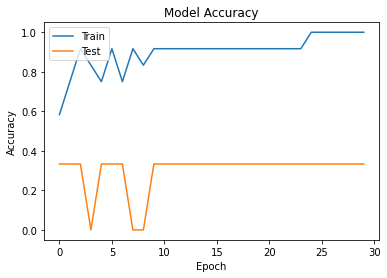

1/1 [==============================] - 1s 928ms/step
Percentage of correct direction predictions: 54.55%


In [252]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming you have loaded your DataFrame named 'df_daily' which contains the data
# df_daily = pd.read_csv('path_to_your_data.csv')

# Define predictor variables
predictor_vars = ['ENA_Returns', 'claimed', 'Total_Stake', 'ETH_Returns', 'Implied_APY', 'SMA_Returns']

# Drop rows with missing values
df_daily = df_daily.dropna(subset=predictor_vars + ['Target_ENA_Returns'])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_daily[predictor_vars])

# Create the target variable (1 if positive return, 0 if negative)
df_daily['Positive_Target_Return'] = (df_daily['Target_ENA_Returns'] > 0).astype(int)

# Reshape data for LSTM (creating sequences)
sequence_length = 30
X = np.array([scaled_features[i - sequence_length:i] for i in range(sequence_length, len(scaled_features))])
y = df_daily['Positive_Target_Return'].values[sequence_length:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Build the LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(sequence_length, len(predictor_vars)))),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the Model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Make predictions
predictions = (model.predict(X_test) > 0.5).astype(int)

# Calculate the percentage of correct predictions
correct_predictions = np.sum(predictions.flatten() == y_test)
total_predictions = len(y_test)
accuracy_percentage = correct_predictions / total_predictions * 100
print(f'Percentage of correct direction predictions: {accuracy_percentage:.2f}%')
